In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLarsCV, LassoLars, lasso_path, Lasso, LassoCV, LinearRegression
# Algorithms
from statistics import mean, stdev, variance
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import Counter
from sklearn.decomposition import PCA
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf
from utils import *
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, VarianceThreshold, RFE, SelectFromModel
from sklearn.svm import LinearSVC

In [2]:
csv = pd.read_csv("monthly_data.csv")


In [3]:
fred = Fred(api_key='3c6ba58d26525f17af95af4fabed24be')


In [4]:
csv2 = csv[50:-17]
csv2 = csv2.drop(['SMU06419406562200001.1', 'SMU21000006056170001SA.1'], axis=1)

In [394]:
data = csv2.dropna(axis="columns")[9::3].reset_index(drop=True)
date = data['Unnamed: 0']
data = data.drop(["Unnamed: 0"], axis=1).drop(data.columns[(data == 0).all()], axis=1)
data

,UNRATE,CPIAUCSL,FEDFUNDS,CSUSHPINSA,M2SL,M1SL,PSAVERT,PAYEMS,INDPRO,TB3MS,...,ESTPIEAMP01GPM,BROSERPA158MFRBDAL,LARTTULA158MFRBDAL,LAUCN310910000000004,LAUCN271470000000004,LFWATTFECAM647N,LFWA55FECAM647S,LFWA55FEKRM647S,LFWA55MAAUM647N,LFWA55MAAUM647S
0,5.4,191.700,2.16,158.671,6417.9,1376.0,6.8,132624.0,98.3318,2.19,...,0.202840,3.101049,-1.716373,19.0,753.0,12983500.0,1731200.0,2.135885e+06,1066453.0,1.065927e+06
1,5.2,193.100,2.63,164.575,6441.5,1370.9,3.4,133156.0,99.3061,2.74,...,0.302725,7.514484,0.772551,22.0,1007.0,13024300.0,1750800.0,2.143861e+06,1076107.0,1.075976e+06
2,5.0,193.700,3.04,172.014,6505.5,1380.1,2.8,133942.0,99.9853,2.97,...,0.100705,2.305359,-3.921781,11.0,830.0,13073700.0,1769300.0,2.173053e+06,1084755.0,1.084697e+06
3,5.0,198.800,3.62,177.610,6604.0,1378.6,2.6,134566.0,98.0779,3.42,...,-0.397219,3.728773,0.385254,9.0,699.0,13125000.0,1787600.0,2.176300e+06,1093207.0,1.093137e+06
4,4.9,198.100,4.16,180.108,6681.2,1374.3,3.6,135149.0,100.9437,3.89,...,0.495050,6.798577,11.977253,13.0,829.0,13164900.0,1804100.0,2.170129e+06,1102186.0,1.101896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,3.6,258.203,1.55,212.347,15329.1,4011.2,7.2,151919.0,109.6527,1.54,...,-0.366781,0.692795,-1.021800,12.0,655.0,15637600.0,2626800.0,4.009206e+06,1447002.0,1.446663e+06
61,4.4,257.989,0.65,215.273,16014.3,4280.2,12.9,150840.0,104.5221,0.29,...,-0.681818,0.431915,-6.577090,13.0,929.0,15678600.0,2631200.0,4.028525e+06,1451676.0,1.451014e+06
62,11.1,257.282,0.08,219.890,18179.6,16601.7,19.0,137840.0,97.8019,0.16,...,0.534759,34.407196,48.553907,12.0,1531.0,15707900.0,2635300.0,4.037798e+06,1454821.0,1.455025e+06
63,7.8,260.149,0.09,226.906,18605.0,17176.3,14.1,141865.0,102.8028,0.11,...,-0.228659,-4.559345,-0.588087,10.0,930.0,15746400.0,2635600.0,4.062025e+06,1456212.0,1.453886e+06


In [395]:
target = pd.read_csv("micron.csv").drop("date", axis=1)[::-1].reset_index().drop("index", axis=1)
target

,sales
0,1308
1,1054
2,1258
3,1362
4,1225
...,...
60,4797
61,5438
62,6056
63,5773


In [396]:
target, date = scrape("T")
target = pd.DataFrame({"sales": target[:0:-1]})
target

,sales
0,10248
1,10317
2,10304
3,12895
4,15756
...,...
60,42779
61,40950
62,42340
63,45691


In [397]:
full = data.join(target)

In [398]:
names = full
scaler = MinMaxScaler()
full = MinMaxScaler().fit_transform(full)
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(full))))
full = np.transpose(full)

In [399]:
since = time.time()
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(full))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(full[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(full)
som.train(full, 50000)
time_elapsed = time.time() - since
print(f"SOM clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

SOM clustering executed in 0.0m 5.629451274871826s 


In [400]:
since = time.time()
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(full)

time_elapsed = time.time() - since
print(f"PCA clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

PCA clustering executed in 0.0m 0.4885826110839844s 


In [401]:
since = time.time()
cluster_count = math.ceil(math.sqrt(len(full))) 
print(cluster_count)
kmeans = KMeans(n_clusters=60,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)
time_elapsed = time.time() - since
print(f"Kmeans on PCA clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

295
Kmeans on PCA clustering executed in 0.0m 44.01368498802185s 


In [402]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(full[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Name")

In [403]:
cluster = clusters.loc["sales"].values
value = clusters["Cluster"].values
index = list(np.where(value ==cluster)[0])
names = list(clusters.index.values[index])
names.remove("sales")
names

['CP0113DKM086NEST',
 'SMU11479009093000001',
 'OWNEDUHN',
 'SMU53000003000000030',
 'CP0430LTM086NEST',
 'SMU46000000700000001',
 'SANGOVTA175MFRBDAL',
 'SMU11479006562200001SA',
 'SMU29441809093000001SA',
 'GAHENR1LFN',
 'SMU48264209092161101SA',
 'SMU48000004322110001SA',
 'CORV741TRADN',
 'SMU20458206562200001',
 'WPU10810262',
 'SMU48000009092161101SA',
 'PCU3279993279990',
 'PCU5241145241142',
 'SRVRPOLVM086NEST',
 'LACR155EDUH',
 'STOC706EDUHN',
 'CP0950PTM086NEST',
 'SMU11479009093000001SA',
 'SMU20928128000000001SA',
 'SMU20928128000000001',
 'PCU3271232712',
 'PCU221122221122416',
 'SPIGOVTN',
 'CP0117SIM086NEST',
 'SMU37395809093000001SA',
 'CP0723LVM086NEST',
 'MABMM301DKM189N',
 'CP1211LVM086NEST',
 'SMU35297400700000001',
 'B070RC1M027SBEA',
 'SMU09757006561000001',
 'SMU42000006562110001SA',
 'SMU18238446562000001SA',
 'PUNT412EDUH',
 'SMU13120209093000001SA',
 'CP0444ATM086NEST',
 'SMU22252200700000001SA',
 'SMU40000006562000001',
 'PCU541310541310',
 'PCU312130312130P'

In [298]:
corrs = {}
for name in data:
    x = data[name]
    
    corrs[abs(x.corr(target["sales"]))] = name

In [299]:
print(sorted(corrs)[::-1])

[0.9589961168276387, 0.9553726376879803, 0.9551440148035445, 0.9538806780507905, 0.9526521014142019, 0.952256905796167, 0.9500449759303234, 0.9494984292273686, 0.9485689822391546, 0.9480973900530232, 0.9480314655463958, 0.9477737001741792, 0.94755650446682, 0.9474963769117725, 0.9474310708579713, 0.9470838313227209, 0.947049085303907, 0.9469626922915505, 0.9469416385290558, 0.9468583154593462, 0.9467707087397665, 0.946638047333239, 0.9459461622959533, 0.9457469470247232, 0.9453891752056348, 0.9444937658487279, 0.944489691665399, 0.9442511943254818, 0.9442315551197317, 0.9441681023925761, 0.944070015744153, 0.9440680440082675, 0.9439987806532524, 0.9438821684666479, 0.943659486315015, 0.9436192948867216, 0.9436048574066809, 0.9435581916010537, 0.9435362894370001, 0.9433036268048678, 0.9432821792030859, 0.9431349670914987, 0.94303654078037, 0.9429211079102928, 0.9425941378955199, 0.942582366194216, 0.9424885233803054, 0.9423353543071423, 0.9422271540092332, 0.9420810938760938, 0.94198991

In [300]:
names = []
for num in sorted(corrs)[:-50:-1]:
    names.append(corrs[num])


In [412]:
data = data[names]

In [413]:
full = data.join(target)

In [414]:
full

,CP0430LTM086NEST,PCU3279993279990,SRVRPOLVM086NEST,CP1211LVM086NEST,SMU42000006562110001SA,CP0444ATM086NEST,SMU19000005552000001,SVKPROINDMISMEI,ESPCPHP1100IXOBM,SMU06409006562300001SA,...,SMU50000006562200001SA,CP1250SEM086NEST,ESPCPHP1100IXEBM,SVNCP110000IXNBM,SMU51000006054150001SA,DAYT339EDUH,SERVRPESM086NEST,PCU327999327999,PCU5413154131,sales
0,70.21,104.8,55.12,57.01,92.940570,75.39,83.4,59.604967,78.71,11.800241,...,10.343657,75.60,78.71,73.96,105.852953,61.843555,78.84,104.6,100.2,10248
1,73.49,105.5,55.95,57.98,93.084673,77.22,83.1,51.304275,80.12,11.977179,...,10.303858,77.19,80.12,74.74,107.494376,62.803609,80.11,105.5,101.0,10317
2,74.79,107.7,56.80,60.00,94.243380,77.99,84.1,52.804400,81.03,12.308206,...,10.484438,78.27,81.03,75.69,109.645895,63.094373,80.78,107.7,102.1,10304
3,75.98,108.7,59.52,61.44,95.757531,78.50,83.9,53.004417,81.82,12.653834,...,10.586158,78.79,81.82,76.83,112.646896,63.526280,81.76,108.4,102.4,12895
4,76.88,109.4,60.70,62.86,97.337649,82.37,84.8,58.204850,82.10,13.009046,...,10.650115,78.84,82.10,76.88,115.628517,63.874182,82.21,109.0,103.1,15756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,112.89,149.6,114.20,116.75,121.000692,107.87,95.4,110.009167,107.37,17.904384,...,14.434639,103.80,107.37,109.10,170.089535,75.106943,106.83,151.3,118.4,42779
61,114.14,149.8,115.65,118.46,121.251702,108.11,94.9,91.607634,108.42,17.848523,...,14.354284,105.21,108.42,110.06,170.581972,75.230568,107.02,151.1,119.0,40950
62,115.37,151.4,116.20,118.73,115.559731,108.51,95.0,101.808484,110.87,17.369762,...,13.726221,104.55,110.87,111.05,170.347847,71.017677,109.38,152.9,119.3,42340
63,115.45,151.0,118.50,119.26,117.001294,108.34,95.1,111.909326,108.69,16.990391,...,13.881971,104.87,108.69,111.42,171.209896,72.424154,107.23,152.7,119.6,45691


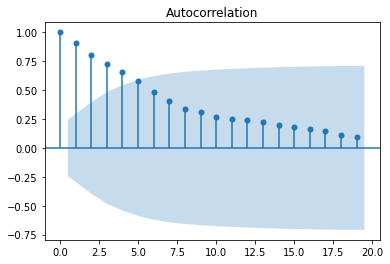

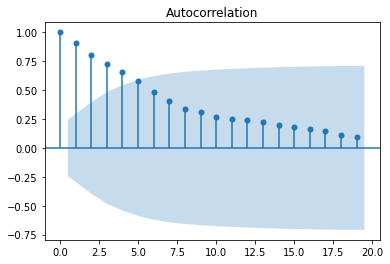

In [415]:
plot_acf(target.values)


In [416]:
X, y = full.iloc[:,:-1],full.iloc[:,-1]


In [417]:
data_dmatrix = xgb.DMatrix(data=X,label=y)



In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [419]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,learning_rate = 0.2,
                max_depth = 10, alpha = 5,n_estimators = 300, tree_method="gpu_hist")
xg_reg.fit(X_train,y_train)


[12:17:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=5, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [420]:
selection = SelectFromModel(xg_reg, threshold=0.002, prefit=True)
select_X_train = selection.transform(X_train)

In [421]:
select_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,learning_rate = 0.2,
                max_depth = 10, alpha = 5,n_estimators = 300, tree_method="gpu_hist")
select_reg.fit(select_X_train,y_train)


[12:17:22] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=5, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [422]:
select_X_test = selection.transform(X_test)
preds = select_reg.predict(select_X_test)


In [423]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1426.615989


In [424]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [425]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3030.266894


In [426]:
clf = LassoCV(cv = 5, normalize=True, max_iter=200000).fit(select_X_train, y_train)

In [427]:
extra = data.columns[np.where(clf.coef_ != 0)[0]]
extra

Index(['PCU3279993279990', 'SRVRPOLVM086NEST', 'CP1211LVM086NEST',
       'SMU42000006562110001SA', 'CP0444ATM086NEST', 'SMU19000005552000001',
       'SVKPROINDMISMEI', 'ESPCPHP1100IXOBM', 'SMU06409006562300001SA',
       'SMU50000006562200001SA', 'CP1250SEM086NEST'],
      dtype='object')

In [428]:
preds = clf.predict(select_X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2593.180197


,SMU12000003200000030,SMU47349804300000001SA,SMU26000002023800008SA,SMU42383005552400001SA,CP0630TRM086NEST,DGDSRX1,SMU36000003000000030SA,SMU31000003231100001SA,SMU06000004340008901,DNXRLTSA,...,SMU34000003231100001SA,TURCPHPLA01IXOBM,SMU47000003231200001SA,SMU42979614300000001,IPG211112N,SMU24251804300000001,SMS04000004300000001,DEUSLRTTO02IXOBSAM,STOC706TRAD,SMU41414204300000001SA
51,-0.0,-0.0,4049.160130,0.0,-0.0,0.0,533.736984,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-405.373524,0.0,0.0,-0.0,-0.0,0.0,-0.0
31,-0.0,-0.0,3542.897697,0.0,-0.0,0.0,466.784070,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-368.798469,0.0,0.0,-0.0,-0.0,0.0,-0.0
63,-0.0,-0.0,4587.979212,0.0,-0.0,0.0,575.098681,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-400.801642,0.0,0.0,-0.0,-0.0,0.0,-0.0
53,-0.0,-0.0,4076.850187,0.0,-0.0,0.0,567.740613,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-403.849563,0.0,0.0,-0.0,-0.0,0.0,-0.0
23,-0.0,-0.0,3481.917227,0.0,-0.0,0.0,473.385147,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-365.750548,0.0,0.0,-0.0,-0.0,0.0,-0.0
40,-0.0,-0.0,3676.287729,0.0,-0.0,0.0,508.842048,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-393.181839,0.0,0.0,-0.0,-0.0,0.0,-0.0
44,-0.0,-0.0,3790.622103,0.0,-0.0,0.0,490.527710,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-414.517288,0.0,0.0,-0.0,-0.0,0.0,-0.0
43,-0.0,-0.0,3786.158971,0.0,-0.0,0.0,488.201635,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-394.705800,0.0,0.0,-0.0,-0.0,0.0,-0.0
27,-0.0,-0.0,3544.526274,0.0,-0.0,0.0,475.035941,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-373.370351,0.0,0.0,-0.0,-0.0,0.0,-0.0
15,-0.0,-0.0,3541.619638,0.0,-0.0,0.0,467.196807,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-362.702627,0.0,0.0,-0.0,-0.0,0.0,-0.0


In [43]:
model = Lasso(alpha = 0.29145927, normalize=True, max_iter=200000)
model.fit(X_train, y_train)
preds = model.predict(X_test )
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 544.647758


In [44]:
X = X.iloc(axis=1)[np.where(clf.coef_ != 0)[0]]

IndexError: positional indexers are out-of-bounds

In [45]:
clf.coef_.shape

(19,)

In [48]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
full.index = pd.DatetimeIndex(date)
data = np.log(full).diff().dropna()
model = VAR(data)
results = model.fit(7)
results.summary()

/home/dwight/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-NOV will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jul, 2021
Time:                     10:13:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -500.470
Nobs:                     56.0000    HQIC:                  -510.568
Log likelihood:           14295.3    FPE:               6.88508e-216
AIC:                     -516.962    Det(Omega_mle):    2.50487e-218
--------------------------------------------------------------------
Results for equation WPS011101
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.015847         0.000000    -11128006.261           0.000
L1.WPS011101                      0.704560         0.000000      5799163.065           0.000
L1.WPU01

In [ ]:
results.plot_acorr()
'model'

In [ ]:
model.select_order(15)
results = model.fit(49, ic='aic')
lag_order = results.k_ar
results.plot_forecast(10)
results.forecast(data.values[-lag_order:], 5)


In [ ]:
values = {}
for name in names:
    d = fred.get_series(name, observation_start="2/1/2021", observation_end = "2/1/2021")
    values[name] = d
    time.sleep(0.3)

In [ ]:
test = pd.DataFrame(values)


In [ ]:
test_data = torch.from_numpy(test.to_numpy())
test_data2 = torch.from_numpy(full[:-3:-1].to_numpy())
test_data = torch.cat([test_data2, test_data]).unsqueeze(0).float()

In [ ]:
model = Model()
model.load_state_dict(torch.load("model.pt"))
model(test_data)

In [ ]:
xg_reg.predict(test)

In [388]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
     

        self.output_block = nn.Sequential(nn.Conv1d(3, 16, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(16, 32, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(32, 32, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(32, 16, 2, 1, 0), nn.ReLU())
        self.fc = nn.Sequential(nn.LazyLinear(512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1))

    def forward(self, x):
        net = self.output_block(x)
        net = net.view(net.shape[0], -1)
        net = self.fc(net)
        
        return net


In [389]:
target[3:]

,sales
3,12895
4,15756
5,15770
6,15638
7,15891
...,...
60,42779
61,40950
62,42340
63,45691


In [390]:
class dataset(Dataset):
    def __init__(self, df, target):
        data = df[1:].reset_index(drop=True)
        sales = target[:-1].reset_index(drop=True)
        self.data = data.join(sales)
        self.target = target[3:].to_numpy()

    def __len__(self):
        return len(self.data)-3
    def __getitem__(self, idx):
        data = self.data.iloc[idx:idx+3].to_numpy()
        target = self.target[idx]
        return torch.tensor(data).float(), torch.tensor(target).float()
        
    

In [391]:
idx = int(len(data) * 0.8)
train, test = data[:idx], data[idx:]
traint, testt = target[:idx], target[idx:]
trainset = dataset(train, traint)
testset = dataset(test, testt)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=True)

In [392]:

def Train(epochs, model, train_loader, test_loader, optimizer, criterion, scheduler):
    valid_loss_min = np.Inf
    min_rmse = np.Inf
    for epoch in range(epochs):
        train_loss = 0.0
        correct = 0.0
        total = 0.0
        valid_loss = 0.0
        rmse = 0.0
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)

            loss = torch.sqrt(criterion(output, labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        model.eval()
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)

            loss = torch.sqrt(criterion(output, labels))

            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        scheduler.step(valid_loss)
        print(f"Train Loss: {train_loss.item()}")
        print(f"Valid Loss: {valid_loss.item()}")
        if valid_loss.item() < valid_loss_min:
            valid_loss_min = valid_loss.item()
            torch.save(model.state_dict(), 'model.pt')
    print(f"Min RMSE: {valid_loss_min}")

In [393]:
model = Model()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, factor=0.8, min_lr=0.000001)
Train(200, model, train_loader, test_loader, optimizer, criterion, scheduler)

/home/dwight/miniconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train Loss: 212084.21875
Valid Loss: 34751.6484375
Train Loss: 12170.345703125
Valid Loss: 14973.8193359375
Train Loss: 16826.228515625
Valid Loss: 9393.1982421875
Train Loss: 7132.54541015625
Valid Loss: 8444.109375
Train Loss: 6540.68896484375
Valid Loss: 9260.7275390625
Train Loss: 6778.0400390625
Valid Loss: 4489.6025390625
Train Loss: 7636.5869140625
Valid Loss: 3165.798828125
Train Loss: 7744.1904296875
Valid Loss: 9119.1689453125
Train Loss: 6466.330078125
Valid Loss: 11670.30078125
Train Loss: 5958.65771484375
Valid Loss: 12151.4970703125
Train Loss: 6199.4912109375
Valid Loss: 11636.6240234375
Train Loss: 6423.8701171875
Valid Loss: 15698.642578125
Train Loss: 5810.0556640625
Valid Loss: 14737.5419921875
Train Loss: 6354.0732421875
Valid Loss: 12842.693359375
Train Loss: 5846.357421875
Valid Loss: 14173.2216796875
Train Loss: 6284.095703125
Valid Loss: 12143.5263671875
Train Loss: 7761.8173828125
Valid Loss: 8109.15771484375
Train Loss: 6933.00146484375
Valid Loss: 7394.309082

Train Loss: 3187.51416015625
Valid Loss: 5385.5419921875
Train Loss: 3144.3740234375
Valid Loss: 3443.700439453125
Train Loss: 2441.0107421875
Valid Loss: 2967.084228515625
Train Loss: 2679.603515625
Valid Loss: 3670.11669921875
Train Loss: 3203.228515625
Valid Loss: 2922.859130859375
Train Loss: 3247.06591796875
Valid Loss: 4124.86181640625
Train Loss: 3209.464111328125
Valid Loss: 3080.948974609375
Train Loss: 2606.7177734375
Valid Loss: 2962.990478515625
Train Loss: 2113.280517578125
Valid Loss: 5224.0498046875
Train Loss: 2980.26708984375
Valid Loss: 1757.9112548828125
Train Loss: 2889.34228515625
Valid Loss: 3230.129150390625
Train Loss: 2970.091552734375
Valid Loss: 3287.017333984375
Train Loss: 2402.49609375
Valid Loss: 3905.336181640625
Train Loss: 2980.35693359375
Valid Loss: 2056.130126953125
Train Loss: 2617.920654296875
Valid Loss: 2425.823486328125
Train Loss: 2329.2734375
Valid Loss: 3096.836669921875
Train Loss: 2209.737060546875
Valid Loss: 2178.12353515625
Train Loss: 

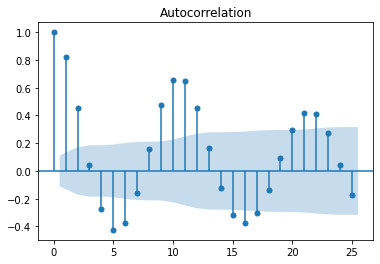

In [264]:
import statsmodels.api as sm
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

sm.graphics.tsa.plot_acf(dta.values.squeeze())
plt.show()

In [69]:
target.shape

(65, 1)

In [429]:
importances = mutual_info_regression(data, np.squeeze(target.values))


In [430]:
feat_importances = pd.Series(importances, data.columns[0:len(data.columns)])

In [431]:
names = feat_importances.where(feat_importances > 1.45).dropna().index

In [432]:
v = VarianceThreshold(threshold=60)
v.fit(data)
data[data.columns[np.where(v.get_support() == True)]]

,CP0430LTM086NEST,PCU3279993279990,SRVRPOLVM086NEST,CP1211LVM086NEST,CP0444ATM086NEST,SVKPROINDMISMEI,ESPCPHP1100IXOBM,CP1250SEM086NEST,ESPCPHP1100IXEBM,SVNCP110000IXNBM,SMU51000006054150001SA,PCU327999327999
0,70.21,104.8,55.12,57.01,75.39,59.604967,78.71,75.60,78.71,73.96,105.852953,104.6
1,73.49,105.5,55.95,57.98,77.22,51.304275,80.12,77.19,80.12,74.74,107.494376,105.5
2,74.79,107.7,56.80,60.00,77.99,52.804400,81.03,78.27,81.03,75.69,109.645895,107.7
3,75.98,108.7,59.52,61.44,78.50,53.004417,81.82,78.79,81.82,76.83,112.646896,108.4
4,76.88,109.4,60.70,62.86,82.37,58.204850,82.10,78.84,82.10,76.88,115.628517,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...
60,112.89,149.6,114.20,116.75,107.87,110.009167,107.37,103.80,107.37,109.10,170.089535,151.3
61,114.14,149.8,115.65,118.46,108.11,91.607634,108.42,105.21,108.42,110.06,170.581972,151.1
62,115.37,151.4,116.20,118.73,108.51,101.808484,110.87,104.55,110.87,111.05,170.347847,152.9
63,115.45,151.0,118.50,119.26,108.34,111.909326,108.69,104.87,108.69,111.42,171.209896,152.7


In [141]:
series = target
dataframe = pd.DataFrame()
for i in range(12,0,-1):
	dataframe['t-'+str(i)] = series.shift(i).values[:,0]
dataframe['t'] = series.values[:,0]
print(dataframe.head(13))
dataframe = dataframe[13:]

       t-12     t-11     t-10      t-9      t-8      t-7      t-6      t-5  \
0       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5       NaN      NaN      NaN      NaN      NaN      NaN      NaN  10248.0   
6       NaN      NaN      NaN      NaN      NaN      NaN  10248.0  10317.0   
7       NaN      NaN      NaN      NaN      NaN  10248.0  10317.0  10304.0   
8       NaN      NaN      NaN      NaN  10248.0  10317.0  10304.0  12895.0   
9       NaN      NaN      NaN  10248.0  10317.0  10304.0  12895.0  15756.0   
10      NaN      NaN  10248.0  10317.0  10304.0  12895.0  15756.0  15770.0   
11      NaN  10248.0  10317.0  10304.0  12895.0  15756.0  15770.

Selected Features:
CP0430LTM086NEST
PCU3279993279990
SRVRPOLVM086NEST
CP1211LVM086NEST
SMU42000006562110001SA
CP0444ATM086NEST
SMU19000005552000001
SVKPROINDMISMEI
ESPCPHP1100IXOBM
SMU06409006562300001SA
SMU06234209092200001SA
SMU50000006562200001SA
CP1250SEM086NEST
ESPCPHP1100IXEBM
SVNCP110000IXNBM
SMU51000006054150001SA
DAYT339EDUH
SERVRPESM086NEST
PCU327999327999
PCU5413154131


ValueError: The number of FixedLocator locations (345), usually from a call to set_ticks, does not match the number of ticklabels (20).

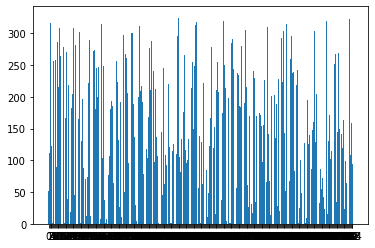

In [411]:
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=20)
fit = rfe.fit(data, np.squeeze(target))
# report selected features
print('Selected Features:')
name = data.columns.values
names = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(name[i])
        names.append(name[i])
# plot feature rank
name = data.columns.values
ticks = [i for i in range(len(name))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.show()

In [383]:
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X_train, np.squeeze(y_train))

RandomForestRegressor(n_estimators=500, random_state=1)

In [384]:
model.feature_importances_

array([0.04077089, 0.04814257, 0.04837878, 0.03957549, 0.04269503,
       0.05409746, 0.06028829, 0.04798283, 0.03224681, 0.03627321,
       0.03875555, 0.04960515, 0.0467811 , 0.05409764, 0.04726574,
       0.03007119, 0.03608897, 0.04270785, 0.05665309, 0.05235085,
       0.04389553, 0.05127597])

In [385]:
names = data.columns[np.where(model.feature_importances_ > 0.01)]

In [386]:
preds = model.predict(X_test)

In [387]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1197.036894
